In [1]:
from modality.datasets import load_biomodal_dataset
from modality.contig_dataset import reduce_byranges
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
ds = load_biomodal_dataset("esE14")
ds =  ds.select_samples(["CEG1485-EL01-D1115-001"])
ds = ds.assign_fractions(numerators=["num_mc", "num_hmc","num_modc"], denominator="num_total_c", min_coverage=0)

In [3]:
bins = np.arange(-3050, 3050, 50)
from modality.annotation import get_tss_dist
x = get_tss_dist(reference = "mm10", ref_pos=ds['ref_position'], strand='+', return_nearest=False)
y = get_tss_dist(reference = "mm10", ref_pos=ds['ref_position'], strand='-', return_nearest=False)
tss_distance = np.where(np.abs(x) < np.abs(y), x, y)

2024-09-16 13:13:12 | INFO | [modality/annotation.py:418] Removing readthrough_gene transcripts for gff (https://ftp.ebi.ac.uk/pub/databases/gencode/Gencode_mouse/release_M25/gencode.vM25.basic.annotation.gff3.gz)
2024-09-16 13:15:22 | INFO | [modality/annotation.py:418] Removing readthrough_gene transcripts for gff (https://ftp.ebi.ac.uk/pub/databases/gencode/Gencode_mouse/release_M25/gencode.vM25.basic.annotation.gff3.gz)


In [4]:
res = ds.reduce_bybins(tss_distance, bins=bins, var=['frac_hmc', 'frac_mc','frac_modc', 'num_total_c'])

In [6]:
df = res[['bin_midpoint', 'sample_id', 'frac_hmc_mean', 'frac_mc_mean', 'frac_modc_mean']].to_dataframe().reset_index()

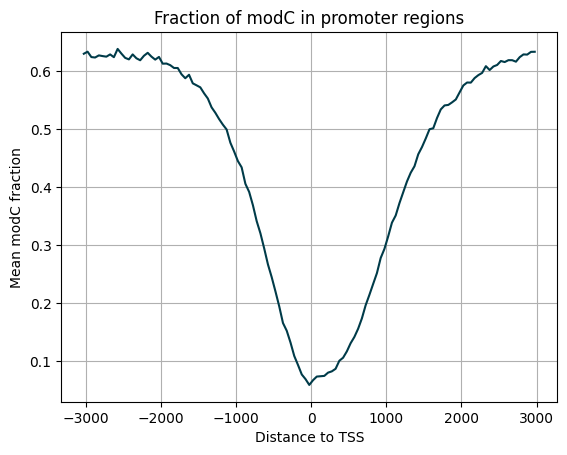

In [7]:
sns.lineplot(data=df, x='bin_midpoint', y='frac_modc_mean', hue='sample_id', legend=0)

plt.title("Fraction of modC in promoter regions")
#Rename the x-axis
plt.xlabel("Distance to TSS")
#Rename the y-axis
plt.ylabel("Mean modC fraction")
plt.grid(True)
plt.show()